In [1]:
#Importing required libraries 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import glob
import os

In [2]:
#read data
energy_df = pd.read_csv('./LCL-June2015v2_10.csv', low_memory = False)
# energy_df.head
# path = './data/Small LCL Data'
# # all_filenames 
# all_filenames = [i for i in [os.path.join(path, os.listdir(path)[0]),os.path.join(path, os.listdir(path)[1])]]
# energy_df = pd.concat([pd.read_csv(f) for f in all_filenames ])
energy_df.head(10)

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000326,Std,2012-04-21 15:00:00.0000000,0.079
1,MAC000326,Std,2012-04-21 15:30:00.0000000,0.096
2,MAC000326,Std,2012-04-21 16:00:00.0000000,0.109
3,MAC000326,Std,2012-04-21 16:30:00.0000000,0.12
4,MAC000326,Std,2012-04-21 17:00:00.0000000,0.175
5,MAC000326,Std,2012-04-21 17:30:00.0000000,0.13
6,MAC000326,Std,2012-04-21 18:00:00.0000000,0.163
7,MAC000326,Std,2012-04-21 18:30:00.0000000,0.193
8,MAC000326,Std,2012-04-21 19:00:00.0000000,0.149
9,MAC000326,Std,2012-04-21 19:30:00.0000000,0.119


In [4]:
#renaming the column KWH
energy_df.rename(columns={'KWH/hh (per half hour) ' : 'KWH'} , inplace=True)

In [5]:
#changing the KWH column format into float
energy_df['KWH'] = pd.to_numeric(energy_df['KWH'],downcast="float", errors='coerce')

In [6]:
energy_df['DateTime'] = pd.to_datetime(energy_df['DateTime'])

In [7]:
energy_df.size

4000000

In [8]:
energy_df.head(10)

,LCLid,stdorToU,DateTime,KWH
0,MAC000326,Std,2012-04-21 15:00:00,0.079
1,MAC000326,Std,2012-04-21 15:30:00,0.096
2,MAC000326,Std,2012-04-21 16:00:00,0.109
3,MAC000326,Std,2012-04-21 16:30:00,0.120
4,MAC000326,Std,2012-04-21 17:00:00,0.175
5,MAC000326,Std,2012-04-21 17:30:00,0.130
6,MAC000326,Std,2012-04-21 18:00:00,0.163
7,MAC000326,Std,2012-04-21 18:30:00,0.193
8,MAC000326,Std,2012-04-21 19:00:00,0.149
9,MAC000326,Std,2012-04-21 19:30:00,0.119


In [7]:
#Grouping the data based on userIds
split_df = dict(tuple(energy_df.groupby('LCLid')))

In [8]:
#Function to split dataframe based on userIds
def splitted_dataframe(x):
    user_df = split_df[list(split_df.keys())[x]]
    return user_df

In [9]:
#Function to remove duplicates from data
def remove_duplicate(data):
    data.duplicated(subset='DateTime')
    bool_series = data["DateTime"].duplicated(keep = False)
    data = data[~bool_series]
    return data
# df[df.duplicated(['DateTime'], keep=False)]

In [21]:
n_input = 5
n_features = 1

In [11]:
#Function to resample data
def resample_data(df):
    df_hour=df.resample('1H').mean().interpolate()
    df_day=df.resample('1D').mean().interpolate()
    df_week=df.resample('7D').mean().interpolate()
    df_month=df.resample('1M').mean().interpolate()
    return df_hour,df_day,df_week,df_month

In [12]:
#Function to split train, test and validation data
def split_test_train(dataframe):
    n = len(dataframe)
    train_df = dataframe[0:int(n*0.7)]
    val_df = dataframe[int(n*0.7):int(n*0.9)]
    test_df = dataframe[int(n*0.9):]
    num_features = dataframe.shape[1]
    return train_df,val_df,test_df,num_features

In [14]:
# Function to Generate Timeseries
def generator(X,y,batch_size=1):
    gtr = TimeseriesGenerator(X, y, length=n_input, batch_size=batch_size)
    return gtr

In [27]:
#Function to build model
def lstn_model(generator):
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator,epochs=20)
    return model

Epoch 1/20
12135/12135 [==============================] - 48s 4ms/step - loss: 0.0120
Epoch 2/20
12135/12135 [==============================] - 45s 4ms/step - loss: 0.0113
Epoch 3/20
12135/12135 [==============================] - 47s 4ms/step - loss: 0.0112
Epoch 4/20
12135/12135 [==============================] - 45s 4ms/step - loss: 0.0112
Epoch 5/20
12135/12135 [==============================] - 44s 4ms/step - loss: 0.0111
Epoch 6/20
12135/12135 [==============================] - 46s 4ms/step - loss: 0.0110
Epoch 7/20
12135/12135 [==============================] - 46s 4ms/step - loss: 0.0109
Epoch 8/20
12135/12135 [==============================] - 42s 3ms/step - loss: 0.0108
Epoch 9/20
12135/12135 [==============================] - 43s 4ms/step - loss: 0.0108
Epoch 10/20
12135/12135 [==============================] - 46s 4ms/step - loss: 0.0107
Epoch 11/20
12135/12135 [==============================] - 46s 4ms/step - loss: 0.0107
Epoch 12/20
12135/12135 [===========================

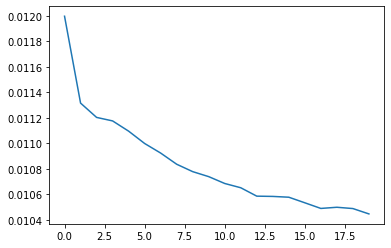

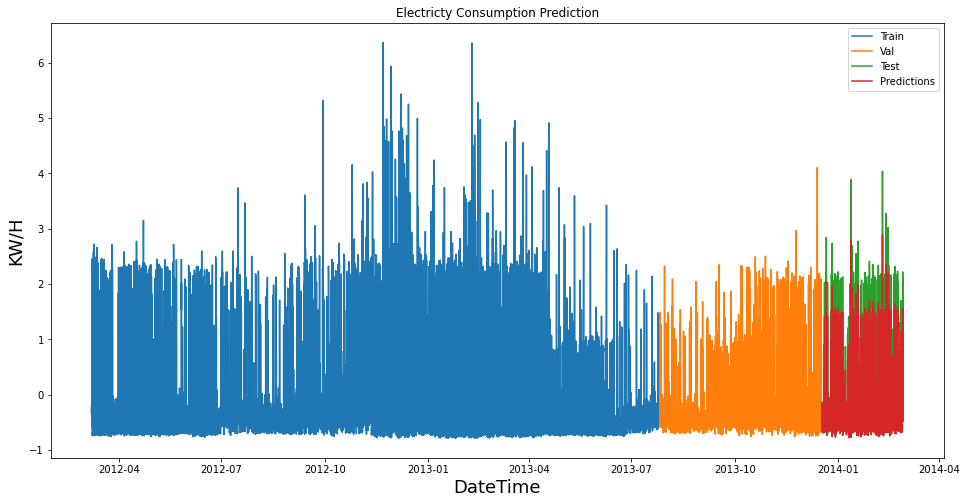

Epoch 1/20
12135/12135 [==============================] - 45s 4ms/step - loss: 0.0120
Epoch 2/20
12135/12135 [==============================] - 44s 4ms/step - loss: 0.0113
Epoch 3/20
12135/12135 [==============================] - 45s 4ms/step - loss: 0.0112
Epoch 4/20
12135/12135 [==============================] - 44s 4ms/step - loss: 0.0112
Epoch 5/20
12135/12135 [==============================] - 46s 4ms/step - loss: 0.0111
Epoch 6/20
12135/12135 [==============================] - 46s 4ms/step - loss: 0.0110
Epoch 7/20
12135/12135 [==============================] - 48s 4ms/step - loss: 0.0109
Epoch 8/20
12135/12135 [==============================] - 47s 4ms/step - loss: 0.0108
Epoch 9/20
12135/12135 [==============================] - 48s 4ms/step - loss: 0.0107
Epoch 10/20
12135/12135 [==============================] - 46s 4ms/step - loss: 0.0107
Epoch 11/20
12135/12135 [==============================] - 47s 4ms/step - loss: 0.0106
Epoch 12/20
12135/12135 [===========================

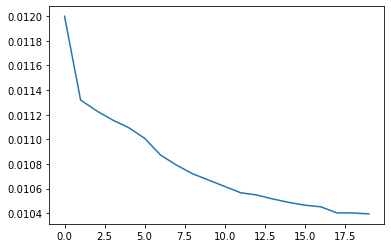

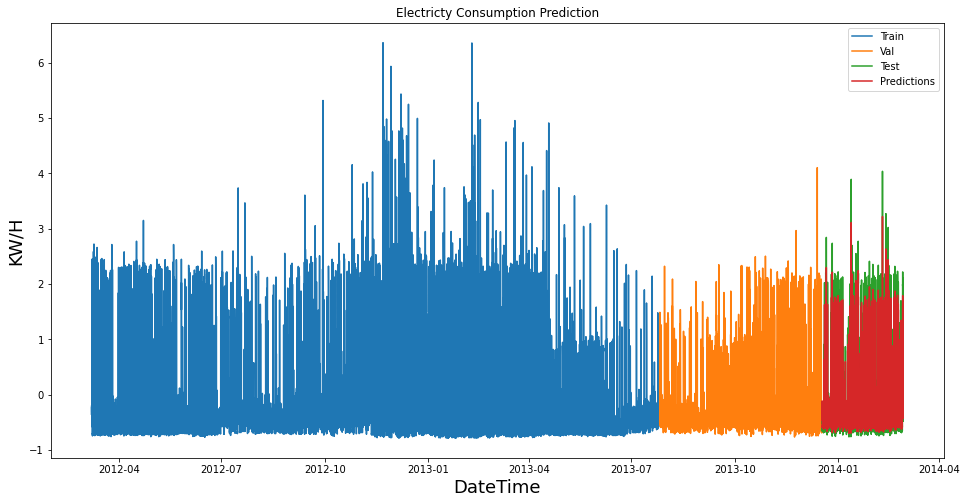

Epoch 1/20
12135/12135 [==============================] - 45s 4ms/step - loss: 0.0120
Epoch 2/20
12135/12135 [==============================] - 46s 4ms/step - loss: 0.0113
Epoch 3/20
12135/12135 [==============================] - 45s 4ms/step - loss: 0.0112
Epoch 4/20
12135/12135 [==============================] - 46s 4ms/step - loss: 0.0111
Epoch 5/20
12135/12135 [==============================] - 45s 4ms/step - loss: 0.0109
Epoch 6/20
12135/12135 [==============================] - 40s 3ms/step - loss: 0.0109
Epoch 7/20
12135/12135 [==============================] - 40s 3ms/step - loss: 0.0108
Epoch 8/20
12135/12135 [==============================] - 42s 3ms/step - loss: 0.0107
Epoch 9/20
12135/12135 [==============================] - 41s 3ms/step - loss: 0.0107
Epoch 10/20
  770/12135 [>.............................] - ETA: 44s - loss: 0.0107

In [ ]:
# Perform data pre-processing training, validation and testing for each user
for x in range(0,5):   # 5 users are considered due to the large number of users
    
    df = splitted_dataframe(1)
    df_new = remove_duplicate(df)
    df_new.set_index(['DateTime'], inplace=True)
    df_hour,df_day,df_week,df_month = resample_data(df_new)
    train_df,val_df,test_df,num_features = split_test_train(df_hour)
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    scaler = MinMaxScaler()
    
    scaled_train = scaler.fit_transform(train_df)
    scaled_test = scaler.fit_transform(test_df)
    scaled_val = scaler.fit_transform(val_df)

#     scaled_train = (train_df - train_mean) / train_std
#     scaled_test = (val_df - train_mean) / train_std
#     scaled_val = (test_df - train_mean) / train_std
#     generator = generator(scaled_train,scaled_train,5)
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=5, batch_size=1)
    model = lstn_model(generator)
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    
#     eval_generator = generator(scaled_val,scaled_val,5)
    eval_generator = TimeseriesGenerator(scaled_val, scaled_val, length=5, batch_size=1)
    model.evaluate(eval_generator)
    
    predictions = model.predict(scaled_test)
    predictions = scaler.inverse_transform(predictions)
    valid = test_df
    valid['Predictions'] = predictions
    plt.figure(figsize= (16,8))
    plt.title('Electricty Consumption Prediction')
    plt.xlabel('DateTime', fontsize = 18)
    plt.ylabel('KW/H', fontsize = 18)
    plt.plot(train_df['KWH'])
    plt.plot(val_df['KWH'])
    plt.plot(valid[['KWH','Predictions']])
    plt.legend(['Train','Val','Test','Predictions'],loc='upper right')
    plt.show()
    
    
    

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
